In [162]:
def _make_report_header(maxN):
    """Return the header and format string for reporting coverage."""
    nw = len(str(maxN))
    frac_width = 2*nw + 1  # width of 300/1000
    frac_header = 'Sample'
    frac_format = '{i:' + str(nw) + 'd}/{n:' + str(nw) + 'd}'
    if frac_width < len(frac_header):
        pad = ''.join([' ' for _ in range(len(frac_header) - frac_width)])
        frac_format = pad + frac_format
    elif len(frac_header) < frac_width:
        pad = ''.join([' ' for _ in range(frac_width - len(frac_header))])
        frac_header = pad + frac_header
    hdr = frac_header + "   Coverage   MinGap   Median   MaxGap     Elapsed     Remaining   Infeasible"
    fmt = frac_format + "    {cov:6.2f}%   {min:6.4f}   {med:6.4f}   {max:6.4f}   {ela:9.2f}     {rem:9.2f}   {inf:10d}"
    return hdr, fmt

def _maxgap(points, fva=None):
    # points has rows = samples, columns = variables

    # make a copy because we're going to sort the columns
    points = points.copy()
    if fva is not None:
        points = np.vstack((fva.minimum, points, fva.maximum))
    points.sort(0)

    gaps = points[1:,:] - points[0:-1,:]
    width = gaps.max(0)
    loc = gaps.argmax(0)
    left = np.zeros(width.size)
    for i in range(width.size):
        left[i] = points[loc[i],i]
    relative = width / (points[-1,:] - points[0,:])
    target = left + width/2

    return relative, target, width



In [163]:
#load data
import numpy as np
import pandas as pd
xls = pd.ExcelFile('data\case6.xlsx')
branch = pd.read_excel(xls, 'branch')
gen = pd.read_excel(xls, 'gen')
bus = pd.read_excel(xls, 'bus')
cost = pd.read_excel(xls, 'cost')
base = 100  

#Y matrix
base = 100
bus_len = bus.shape[0]
gen_len = len(gen['bus'].ravel())

Ybus = np.matrix(np.zeros([bus_len,bus_len]),dtype=complex)
shunt = np.zeros(bus_len, dtype=complex)
x = [pd.DataFrame() for i in range(bus_len)]
for i in range(bus_len):  
    x[i] = branch.loc[branch['fbus'] == i]
    fro = [j for j in x[i]['tbus']]
    fro = pd.DataFrame(fro)
    for j in range(len(fro)):
        Ybus[i-1,fro.loc[j][0]-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        Ybus[fro.loc[j][0]-1,i-1] =  -1/complex(pd.DataFrame(x[i]['r']).iloc[j][0],pd.DataFrame(x[i]['x']).iloc[j][0])
        shunt[j] = complex(0,sum(x[i]['b'])/2)

for i in range(bus_len):
    Ybus[i,i] = np.sum(Ybus[i,:])*(-1) + complex(0,sum(branch.loc[(branch['fbus']==i+1) | (branch['tbus']==i+1)]['b'])/2)


# declare variables
Pd = np.zeros(bus_len)
Qd = np.zeros(bus_len)
Vmax = np.zeros(bus_len)
Vmin = np.zeros(bus_len)
Pmax = np.zeros(bus_len)
Pmin = np.zeros(bus_len)
Qmax = np.zeros(bus_len)
Qmin = np.zeros(bus_len)
cost_lin = np.zeros(bus_len)
cost_quad = np.zeros(bus_len)

for i in range(bus_len):
    Pd[i] = bus['Pd'][i]/base
    Qd[i] = bus['Qd'][i]/base
    Vmax[i] = bus['Vmax'][i]
    Vmin[i] = bus['Vmin'][i]

for i in range(gen_len):
    k = i
    i = gen['bus'].ravel()[i]
    Pmax[i-1] = gen.loc[gen['bus'] == i]['Pmax'].ravel()[0]/base
    Pmin[i-1] = gen.loc[gen['bus'] == i]['Pmin'].ravel()[0]/base
    Qmax[i-1] = gen.loc[gen['bus'] == i]['Qmax'].ravel()[0]/base
    Qmin[i-1] = gen.loc[gen['bus'] == i]['Qmin'].ravel()[0]/base
    cost_lin[i-1] = cost['lin'][k]*base
    cost_quad[i-1] = cost['quad'][k]*base**2

p = pd.DataFrame([gen['Pmin'],gen['Pmax']]).T
p.columns = ['minimum', 'maximum']
p = p.T
p.columns = ['P%s' % (i+1) for i in range(gen_len)]
p = p.T/base

q = pd.DataFrame([gen['Qmin'],gen['Qmax']]).T
q.columns = ['minimum', 'maximum']
q = q.T
q.columns = ['Q%s' % (i+1) for i in range(gen_len)]
q = q.T/base

v = pd.DataFrame([bus['Vmin'],bus['Vmax']]).T
v.columns = ['minimum', 'maximum']
v = v.T
v.columns = ['V%s' % (i+1) for i in range(bus_len)]
v = v.T

# frames = [p,q,v]
# fva = pd.concat(frames)
# fva = p
fva = pd.concat([p,q])

In [164]:
# Case 1: Static Load
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len))

    model.vars = Var(range(len(fva)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(gen_len):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
        model.c.add(expr = model.vars[i+gen_len] <= fva.iloc[i+gen_len]['maximum'])
        model.c.add(expr = model.vars[i+gen_len] >= fva.iloc[i+gen_len]['minimum'])
    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
                holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 +  np.random.uniform(0,Pd[i]) == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 +  np.random.uniform(0,Qd[i]) == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 1)

    solution = SolverFactory('ipopt').solve(model)

    # Line flow data
    Pxyp = np.zeros(len(branch))
    Pyxp = np.zeros(len(branch))
    Qxyp = np.zeros(len(branch))
    Qyxp = np.zeros(len(branch))
    for i in range(len(branch)): 
        x = int(branch.loc[i]['fbus'])-1
        y = int(branch.loc[i]['tbus'])-1
        Pxyp[i] = (model.v[x].value**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*cos(model.t[x].value-model.t[y].value-cmath.polar(Ybus[x,y])[1])
        Qxyp[i] = -(model.v[x].value**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*sin(model.t[x].value-model.t[y].value-cmath.polar(Ybus[x,y])[1])     
        Pyxp[i] = (model.v[y].value**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*cos(model.t[y].value-model.t[x].value-cmath.polar(Ybus[x,y])[1])
        Qyxp[i] = -(model.v[y].value**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x].value*model.v[y].value*cmath.polar(Ybus[x,y])[0]*sin(model.t[y].value-model.t[x].value-cmath.polar(Ybus[x,y])[1])     

    #Return result to the Gapsplit algorithm
    
    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result

    else:
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None

In [ ]:
# Case 2: load as an Opt Variable
def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len))

    model.vars = Var(range(len(fva)))
    model.load_p = Var(range(bus_len))
    model.load_q = Var(range(bus_len))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(gen_len):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
        model.c.add(expr = model.vars[i+gen_len] <= fva.iloc[i+gen_len]['maximum'])
        model.c.add(expr = model.vars[i+gen_len] >= fva.iloc[i+gen_len]['minimum'])
    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 
        model.c.add(expr = model.load_p[i] <= Pd[i])
        model.c.add(expr = model.load_q[i] <= Qd[i])
        model.c.add(expr = model.load_p[i] >= 0)
        model.c.add(expr = model.load_q[i] >= 0)

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
                holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 +  model.load_p[i] == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 +  model.load_q[i] == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 1)

    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result
#         return np.array([model.load_p[i].value for i in range(bus_len)])
    

    else:
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None

In [195]:
writer = pd.ExcelWriter('data/samples/load.xlsx')
data = pd.concat([pd.DataFrame(_Pd),pd.DataFrame(_Qd)],axis=1)
data.columns = [i for i in range(2*bus_len)]
data.to_excel(writer,'6bus_load')
writer.save()

In [169]:
# Case 3: Load sampled from a distribution
#bus = number of buses, n = sample of marginal loads, a&b = parameter of distribution, size = number of load samples
def load_data(bus, n, a, b, corr, size):
    from scipy.stats import beta
    lp = ['' for i in range(bus)]
    means = np.zeros(bus)
    std = np.zeros(bus)
#     cov = np.zeros([bus,bus])
    
    for i in range(bus):
        lp[i] = beta.rvs(a,b, size=n)
        means[i] = lp[i].mean()
        std[i] = lp[i].std()/3
        
    hold1 = np.matrix([std]).T*np.matrix([std])
    hold2 = np.matrix((np.ones([bus,bus])-np.identity(bus))*corr + np.identity(bus))
    cov = np.multiply(hold1, hold2)
            
    return np.random.multivariate_normal(means, cov, size)

def _generate_sample(
        primary_var, primary_lb, primary_ub,
        secondary_vars=None, secondary_targets=None, secondary_weights=None):
    #Create a model
    model = ConcreteModel()
    model.t = Var(range(bus_len))
    model.v = Var(range(bus_len))

    model.vars = Var(range(len(fva)))

    model.c = ConstraintList()

    #Bus voltage angle initial condition
    model.c.add(model.t[0] == 0)

    #Limits constraints
    for i in range(gen_len):
        model.c.add(expr = model.vars[i] <= fva.iloc[i]['maximum'])
        model.c.add(expr = model.vars[i] >= fva.iloc[i]['minimum'])
        model.c.add(expr = model.vars[i+gen_len] <= fva.iloc[i+gen_len]['maximum'])
        model.c.add(expr = model.vars[i+gen_len] >= fva.iloc[i+gen_len]['minimum'])
    for i in range(bus_len):
        model.c.add(expr = model.v[i] <= Vmax[i])
        model.c.add(expr = model.v[i] >= Vmin[i]) 

    model.vars[primary_var].setlb(primary_lb)
    model.vars[primary_var].setub(primary_ub)


    if secondary_vars is not None:
        quad_exp = 0
        for i, sec in enumerate(secondary_vars):
            quad_exp += secondary_weights[i] * (model.vars[sec]-secondary_targets[i])**2

        #Nodal equations
        count = 0
        for i in range(bus_len):
            if (np.any(gen['bus'].ravel()-1==[i])):
                holder1 = model.vars[count]
                holder2 = model.vars[count+gen_len]
                count = count+1
            else:
                holder1 = 0
                holder2 = 0

            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*cos(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder1 +  Pd[i] == 0)
            model.c.add(expr = sum([model.v[i]*model.v[j]*cmath.polar(Ybus[i,j])[0]*sin(model.t[i]-model.t[j]-cmath.polar(Ybus[i,j])[1]) for j in range(bus_len)]) - holder2 +  Qd[i] == 0)

        #Line flow constraints
        for i in range(len(branch)): 
            x = int(branch.loc[i]['fbus'])-1
            y = int(branch.loc[i]['tbus'])-1
            val = (branch.loc[i]['rateA']/100)
            if(val == 0):
                val = 100
        #    With phasor
            Pxy = (model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])
            Qxy =-(model.v[x]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[x]-model.t[y]-cmath.polar(Ybus[x,y])[1])     

            Pyx = (model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*cos(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*cos(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])
            Qyx =-(model.v[y]**2)*cmath.polar(Ybus[x,y])[0]*sin(cmath.polar(Ybus[x,y])[1]) - model.v[x]*model.v[y]*cmath.polar(Ybus[x,y])[0]*sin(model.t[y]-model.t[x]-cmath.polar(Ybus[x,y])[1])     

            model.c.add(expr = (Pxy**2 + Qxy**2)<= val**2)
            model.c.add(expr = (Pyx**2 + Qyx**2)<= val**2)


        model.cost = Objective(expr = quad_exp)
    else:
        model.cost = Objective(expr = 1)

    solution = SolverFactory('ipopt').solve(model)

    if (solution.solver.status == SolverStatus.ok) and (solution.solver.termination_condition == TerminationCondition.optimal):
        # Do something when the solution in optimal and feasible
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        result = np.array([model.vars[i].value for i in range(len(fva))])
        return result

    else:
        model.vars[primary_var].setlb(fva.iloc[primary_var]['minimum'])
        model.vars[primary_var].setub(fva.iloc[primary_var]['maximum'])
        return None

In [ ]:
import time
import numpy as np
import pandas as pd
import cmath
from pyomo.opt import SolverFactory
from pyomo.environ import *

n = 1000; max_tries = None; r_w = 50000;
primary='max'; primary_tol=0.001;
secondary_frac=1;
min_range=1e-5;
enforce_range=True;
report_interval=0.25;
quiet=False

report = lambda s: print(s)

if secondary_frac >= 1.0:
    n_secondary = secondary_frac
else:
    n_secondary = np.floor(secondary_frac * len(fva)).astype(int)
    
idxs = (fva.maximum - fva.minimum >= min_range).to_numpy().nonzero()[0]
weights = (1/(fva.maximum - fva.minimum)**2).to_numpy()
report("Targeting {}/{} unblocked primary variables.".format(len(idxs), len(fva)))
report("Targeting {} secondary variables.".format(n_secondary))

report_header, report_format = _make_report_header(n)
report("\n" + report_header)
if report_interval < 1.0:
    report_interval = np.floor(report_interval * n).astype(int)

samples = np.zeros((r_w, len(fva)))
i_samples = np.zeros((n, len(fva)))

k = 0
infeasible_count = 0
counter = 0
true_s = 0

primary_var = -1
try_ = 0
start_time = time.time()

var_p = np.array([])

#Define load data for case 3
_Pd = load_data(bus = bus_len, n=100, a=5, b=5, corr=0.75, size=2*n)
_Qd = _Pd*0.15

while True:
    if max_tries is not None and try_ >= max_tries:
        break
    try_ += 1
    
    relative, target, width = _maxgap(samples[0:k,idxs], fva.iloc[idxs,:])
    
    if (counter >= 2) :
        counter = 0
        primary_var = np.random.choice(len(idxs), 1).astype(int)[0]
    else:
        primary_var = np.argmax(relative)
    

#     primary_var = np.argmax(width)
    var_p = np.append(var_p,primary_var)
    
    primary_target = target[primary_var]
    primary_lb = primary_target - primary_tol*width[primary_var]
    primary_ub = primary_target + primary_tol*width[primary_var]
    secondary_vars = np.random.choice(len(idxs), n_secondary, replace=False)

#     temp = np.argpartition(-width, n_secondary)
#     secondary_vars = temp[:n_secondary]

#     temp = np.partition(-width, n_secondary)
#     result = -temp[:n_secondary]
    
    secondary_targets = target[secondary_vars]
    secondary_weights = weights[idxs[secondary_vars]]
    
    Pd = _Pd[true_s]
    Qd = _Qd[true_s]

    new_sample =  _generate_sample(
                idxs[primary_var], primary_lb, primary_ub,
                idxs[secondary_vars], secondary_targets, secondary_weights)


    if new_sample is not None:
        if enforce_range:
            new_sample[new_sample > fva.maximum] = fva.maximum[new_sample > fva.maximum]
            new_sample[new_sample < fva.minimum] = fva.minimum[new_sample < fva.minimum]

        samples[k,:] = new_sample
        i_samples[true_s,:] = new_sample
    
    
        k += 1
        true_s += 1
        
        #Reporting true samples {addition}
        relative, target, width = _maxgap(i_samples[0:true_s,idxs], fva.iloc[idxs,:])
        
        if k % report_interval == 0:
            elapsed = time.time() - start_time
            remaining = elapsed / k * (n - k)
            report(report_format.format(
                    i=true_s, n=n, cov=100*(1-np.mean(relative)),
                    min=np.min(relative), med=np.median(relative),
                    max=np.max(relative), ela=elapsed, rem=remaining,
                    inf=infeasible_count))
    else:
#         addition for infeasible samples
        samples[k,primary_var] = target[primary_var]
        w = idxs
        w = np.delete(w,idxs[primary_var])
        for i in range(len(w)):
            samples[k,w[i]] = fva['minimum'][w[i]]
        k += 1
        
        infeasible_count += 1
        counter += 1
           

    if true_s >= n: break
#     if k >= r_w: break

if true_s < n:
    # max_tries reached; return fewer than n samples
    i_samples = i_samples[:true_s,:]

if k < r_w:
    # max_tries reached; return fewer than n samples
    samples = samples[:k,:]

ans = pd.DataFrame(data=samples,columns=fva.maximum.index)
t_ans = pd.DataFrame(data=i_samples,columns=fva.maximum.index)

In [28]:
var_p = var_p.astype(str)
for n, i in enumerate(var_p):
    if i == '0.0':
        var_p[n] = 'P1'
    if i == '1.0':
        var_p[n] = 'P2'
    if i == '2.0':
        var_p[n] = 'P3'
    if i == '3.0':
        var_p[n] = 'Q1'
    if i == '4.0':
        var_p[n] = 'Q2'
    if i == '5.0':
        var_p[n] = 'Q3'

writer = pd.ExcelWriter('samples.xlsx')
ans.to_excel(writer,'raw')
t_ans.to_excel(writer,'valid')
pd.DataFrame(var_p).to_excel(writer,'Primary_var')
writer.save()

Text(0.5, 0, 'P3')

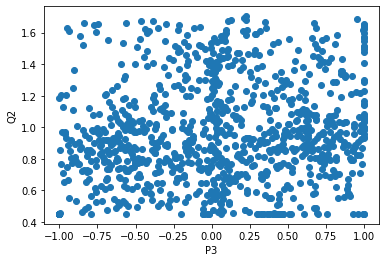

In [180]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x = t_ans['Q2'].to_numpy()
y = t_ans['P3'].to_numpy()
ax.scatter(x,y)
ax.set_ylabel('Q2')
ax.set_xlabel('P3')
# fig.savefig('P2-P1', dpi=500)